# Same as cat_price_predict scratchwork, using Alpaca API instead of FMP API.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import requests

%matplotlib inline

In [2]:
 # Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [3]:
 # Set the ticker
cat_ticker = "CAT"

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 4
start_date = pd.Timestamp("2017-07-11", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-06-29", tz="America/New_York").isoformat()


cat_data = api.get_barset(
    cat_ticker,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

cat_data.head()

CAT                                 
                             open    high     low   close   volume
time                                                              
2017-07-11 00:00:00-04:00  105.50  108.46  104.80  105.80  2086502
2017-07-12 00:00:00-04:00  106.48  109.52  106.43  106.50  2783543
2017-07-13 00:00:00-04:00  106.42  106.77  105.52  106.03  2453505
2017-07-14 00:00:00-04:00  106.08  106.88  105.60  106.32  2655182
2017-07-17 00:00:00-04:00  105.55  108.84  105.53  106.39  2123063

In [4]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [5]:
# Define the window size
window_size = 100

# Set the index of the feature and target columns
feature_column = 3
target_column = 3

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(cat_data, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[105.8    106.5    106.03   106.32   106.39   105.41   107.81   105.66
  104.94   108.43   112.77   111.76   112.6    112.33   112.19   111.35
  113.07   113.56   114.32   114.7    114.42   114.34   111.4    112.87
  111.95   111.89   112.35   113.18   112.16   113.58   115.8    114.755
  113.     113.56   113.29   114.21   115.73   117.48   118.3    116.47
  115.17   115.95   116.     117.03   119.07   119.63   118.62   121.37
  123.79   122.81   122.92   122.86   124.4    122.4    124.54   124.51
  123.29   122.78   122.79   123.57   124.78   124.44   124.97   126.8599
  126.21   126.61   127.98   128.69   131.47   128.52   131.27   129.51
  131.33   130.42   136.91   136.82   136.94   136.49   136.49   134.5
  136.289  136.45   135.32   136.39   137.48   135.97   135.36   135.17
  136.53   136.22   132.81   136.36   136.11   135.59   137.6    136.68
  137.42   137.2    137.65   138.06  ]
 [106.5    106.03   106.32   106.39   105.41   107.81   105.66   104.94
  108.

In [6]:
# Manually splitting the data (70% for test, remaining 30% for training)
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [7]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [8]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.13193261]
  [0.13855764]
  [0.13410941]
  [0.13685406]
  [0.13724379]
  [0.12724199]
  [0.14977932]
  [0.12486428]
  [0.11834962]
  [0.14992761]
  [0.17697842]
  [0.15769871]
  [0.16162718]
  [0.15671413]
  [0.15564232]
  [0.14921145]
  [0.16237942]
  [0.16613076]
  [0.17194917]
  [0.17485837]
  [0.17271475]
  [0.17210228]
  [0.14959424]
  [0.16084826]
  [0.15380493]
  [0.14604448]
  [0.14763311]
  [0.15361337]
  [0.14318967]
  [0.1532059 ]
  [0.16886506]
  [0.16149397]
  [0.14911476]
  [0.15306482]
  [0.15116033]
  [0.15764971]
  [0.16837131]
  [0.18071524]
  [0.18649926]
  [0.17359103]
  [0.1643401 ]
  [0.16983926]
  [0.17019177]
  [0.17745347]
  [0.19183587]
  [0.19578398]
  [0.18866328]
  [0.20805133]
  [0.2251128 ]
  [0.21820361]
  [0.21897913]
  [0.21855612]
  [0.22941342]
  [0.21531303]
  [0.23040045]
  [0.23018895]
  [0.2215877 ]
  [0.2179921 ]
  [0.21806261]
  [0.22356176]
  [0.2320925 ]
  [0.22969543]
  [0.22668766]
  [0.23962687]
  [0.23047504]
  

In [9]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [10]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = window_size
# 20% of neurons to be dropped out
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [11]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [12]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
7/7 [==============================] - 1s 66ms/step - loss: 0.0758
Epoch 2/20
7/7 [==============================] - 0s 63ms/step - loss: 0.0088
Epoch 3/20
7/7 [==============================] - 0s 62ms/step - loss: 0.0043
Epoch 4/20
7/7 [==============================] - 0s 62ms/step - loss: 0.0054
Epoch 5/20
7/7 [==============================] - 0s 62ms/step - loss: 0.0033
Epoch 6/20
7/7 [==============================] - 0s 62ms/step - loss: 0.0039
Epoch 7/20
7/7 [==============================] - 0s 62ms/step - loss: 0.0031
Epoch 8/20
7/7 [==============================] - 0s 62ms/step - loss: 0.0034
Epoch 9/20
7/7 [==============================] - 0s 63ms/step - loss: 0.0029
Epoch 10/20
7/7 [==============================] - 0s 63ms/step - loss: 0.0029
Epoch 11/20
7/7 [==============================] - 0s 63ms/step - loss: 0.0035
Epoch 12/20
7/7 [==============================] - 0s 62ms/step - loss: 0.0029
Epoch 13/20
7/7 [==============================] - 0s 62ms/st

In [18]:
model.evaluate(X_test, y_test, verbose=0)

0.00883047841489315

In [19]:
predicted = model.predict(X_test)

In [20]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(predicted)

In [22]:
cat_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = cat_data.index[-len(real_prices): ]) 

# Show the DataFrame's head
cat_actual_predicted.head()

,Actual,Predicted
time,,
2020-06-04 00:00:00-04:00,118.001778,118.001778
2020-06-05 00:00:00-04:00,119.259056,119.259056
2020-06-08 00:00:00-04:00,120.700645,120.700645
2020-06-09 00:00:00-04:00,122.380066,122.380066
2020-06-10 00:00:00-04:00,124.167389,124.167389


In [23]:
cat_actual_predicted.tail()

,Actual,Predicted
time,,
2021-06-23 00:00:00-04:00,214.915833,214.915833
2021-06-24 00:00:00-04:00,212.386475,212.386475
2021-06-25 00:00:00-04:00,210.605835,210.605835
2021-06-28 00:00:00-04:00,209.523788,209.523788
2021-06-29 00:00:00-04:00,209.051086,209.051086


<AxesSubplot:title={'center':'Actual Vs. Predicted CAT Prices (6/2020 - 6/2021)'}, xlabel='time'>

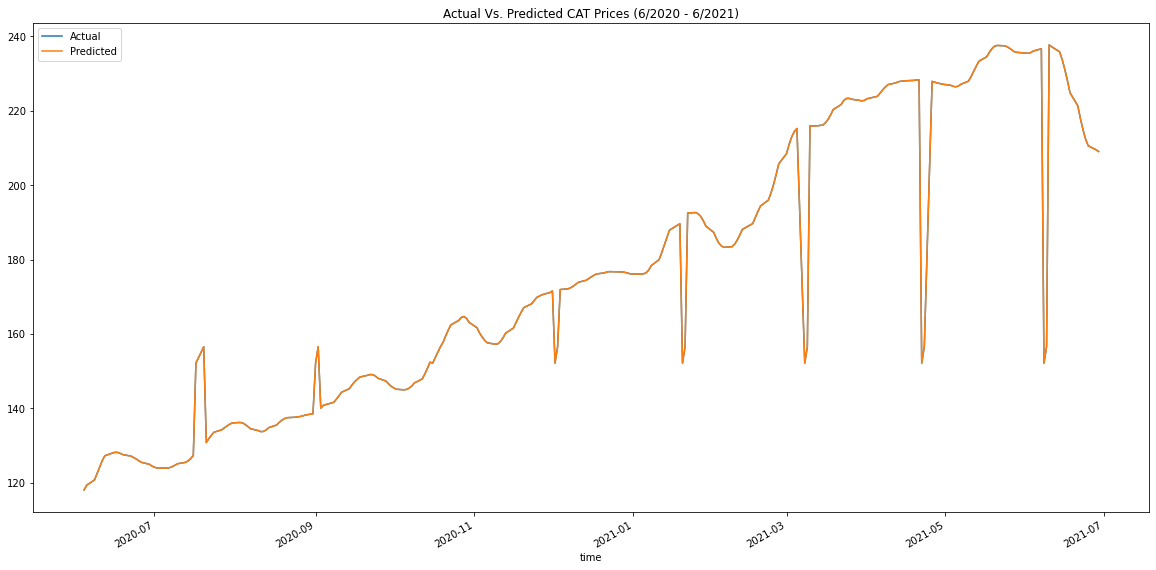

In [24]:
cat_actual_predicted.plot(title="Actual Vs. Predicted CAT Prices (6/2020 - 6/2021)", figsize=(20,10))